# Single Stock Triple-EWMA Crossover Strategy

- Short when fast MA < medium MA < slow MA
- Exit short when fast MA > medium MA


- Long when fast MA > medium MA > slow MA
- Exit long when fast MA < medium MA

## Import libraries

In [37]:
pip install yfinance

In [38]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy import stats
plt.style.use("seaborn-whitegrid")

## Load stock data

In [39]:
ticker = "AAPL"
aapl_df = yf.download(tickers=ticker, period="max", interval="1d", group_by="ticker", auto_adjust=True)
aapl_df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
1980-12-12,0.100600,0.101037,0.100600,0.100600,469033600
1980-12-15,0.095789,0.095789,0.095352,0.095352,175884800
1980-12-16,0.088790,0.088790,0.088353,0.088353,105728000
1980-12-17,0.090540,0.090977,0.090540,0.090540,86441600
1980-12-18,0.093165,0.093602,0.093165,0.093165,73449600
...,...,...,...,...,...
2021-08-06,146.350006,147.110001,145.630005,146.139999,54067400
2021-08-09,146.199997,146.699997,145.520004,146.089996,48908700
2021-08-10,146.440002,147.710007,145.300003,145.600006,68922200


## Get close prices

In [40]:
close_df = aapl_df.copy()
close_df = close_df.drop(columns=["Open", "High", "Low", "Volume"])
close_df = close_df.rename(columns={"Close":"AAPL"})
close_df

,AAPL
Date,
1980-12-12,0.100600
1980-12-15,0.095352
1980-12-16,0.088353
1980-12-17,0.090540
1980-12-18,0.093165
...,...
2021-08-06,146.139999
2021-08-09,146.089996
2021-08-10,145.600006


## Visualise adjusted close prices

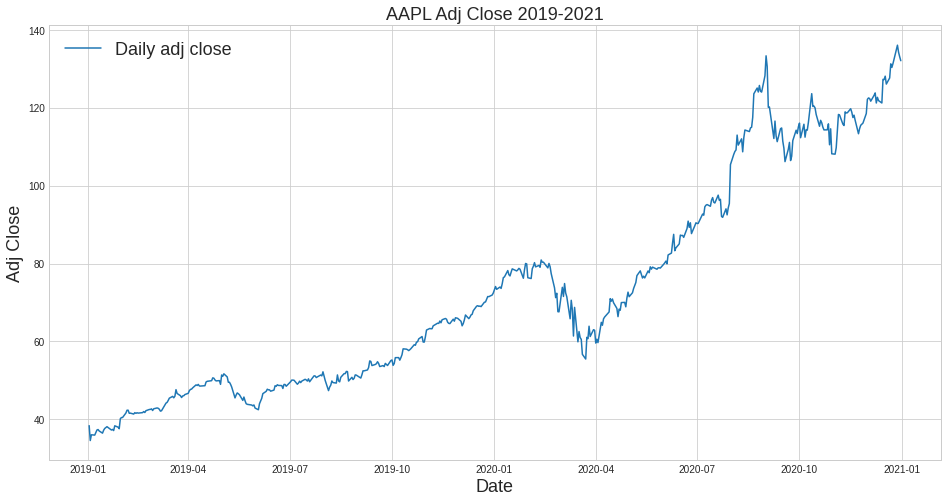

In [41]:
plt.figure(figsize=(16,8))
plt.plot(close_df.loc["2019-01-01":"2021-01-01", "AAPL"], label="Daily adj close")
plt.title("AAPL Adj Close 2019-2021", fontsize=18)
plt.legend(fontsize=18)
plt.xlabel("Date", fontsize=18)
plt.ylabel("Adj Close", fontsize=18)
plt.show()

## Exponentially Weighted Moving Average (EWMA)

In [42]:
def EWMA(df, period):
  return df.ewm(span=period).mean()

In [43]:
fast_ewma_df = close_df.copy()
fast_ewma_df = EWMA(fast_ewma_df, 10)
fast_ewma_df

,AAPL
Date,
1980-12-12,0.100600
1980-12-15,0.097713
1980-12-16,0.093951
1980-12-17,0.092827
1980-12-18,0.092924
...,...
2021-08-06,146.216916
2021-08-09,146.193840
2021-08-10,146.085870


In [44]:
medium_ewma_df = close_df.copy()
medium_ewma_df = EWMA(medium_ewma_df, 20)
medium_ewma_df

,AAPL
Date,
1980-12-12,0.100600
1980-12-15,0.097845
1980-12-16,0.094359
1980-12-17,0.093257
1980-12-18,0.093235
...,...
2021-08-06,144.943822
2021-08-09,145.052981
2021-08-10,145.105079


In [45]:
slow_ewma_df = close_df.copy()
slow_ewma_df = EWMA(slow_ewma_df, 30)
slow_ewma_df

,AAPL
Date,
1980-12-12,0.100600
1980-12-15,0.097888
1980-12-16,0.094496
1980-12-17,0.093406
1980-12-18,0.093351
...,...
2021-08-06,143.104301
2021-08-09,143.296926
2021-08-10,143.445512


## Visualise EWMAs with adjusted close prices

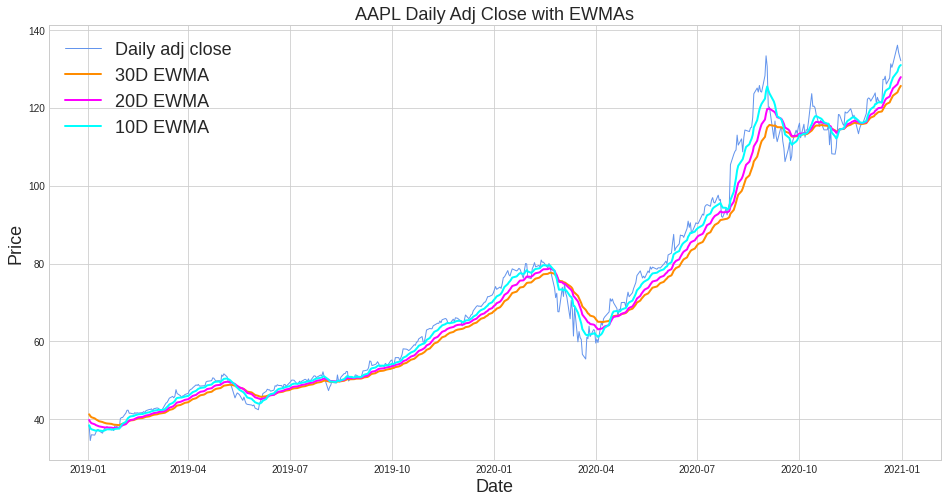

In [46]:
plt.figure(figsize=(16,8))
plt.plot(close_df.loc["2019-01-01":"2021-01-01","AAPL"], alpha=1.0, label="Daily adj close", linewidth=1, color="cornflowerblue", zorder=1)
plt.plot(slow_ewma_df.loc["2019-01-01":"2021-01-01","AAPL"], alpha=1.0, label="30D EWMA", linewidth=2, color="darkorange", zorder=2)
plt.plot(medium_ewma_df.loc["2019-01-01":"2021-01-01","AAPL"], alpha=1.0, label="20D EWMA", linewidth=2, color="magenta", zorder=3)
plt.plot(fast_ewma_df.loc["2019-01-01":"2021-01-01","AAPL"], alpha=1.0, label="10D EWMA", linewidth=2, color="cyan", zorder=4)
plt.title("AAPL Daily Adj Close with EWMAs", fontsize=18)
plt.legend(fontsize=18)
plt.xlabel("Date", fontsize=18)
plt.ylabel("Price", fontsize=18)
plt.show()

## Compute long and short signals

- Short when fast MA < medium MA < slow MA
- Exit short when fast MA > medium MA

- Long when fast MA > medium MA > slow MA
- Exit long when fast MA < medium MA

In [47]:
def get_long_short(fast_ma, medium_ma, slow_ma):
  # create initial long/short signal dataframe with all zeros
  long_short = (fast_ma*0).fillna(0).astype(np.int)

  # create long entry signals when fast ma > medium ma > slow ma
  enter_long_signals = ((fast_ma > medium_ma) & (medium_ma > slow_ma)).astype(np.int)
  # create long exit signals when fast ma < medium ma
  exit_long_signals = (fast_ma < medium_ma).astype(np.int)

  # create short entry signals when fast ma < medium ma < slow ma
  enter_short_signals = ((fast_ma < medium_ma) & (medium_ma < slow_ma)).astype(np.int)
  # create short exit signals when fast ma > medium ma
  exit_short_signals = (fast_ma > medium_ma).astype(np.int)

  # combine signals
  long_signals = long_short + enter_long_signals - exit_long_signals
  short_signals = long_short + enter_short_signals - exit_short_signals

  return long_signals, short_signals

In [48]:
# compute signals b/w 2019 and 2021 and cut ewma and close to that timeframe too
close_df = close_df.loc["2019-01-01":"2021-01-01", :]
fast_ewma_df = fast_ewma_df.loc["2019-01-01":"2021-01-01", :]
medium_ewma_df = medium_ewma_df.loc["2019-01-01":"2021-01-01", :]
slow_ewma_df = slow_ewma_df.loc["2019-01-01":"2021-01-01", :]
long_signals, short_signals = get_long_short(fast_ewma_df, medium_ewma_df, slow_ewma_df)

In [49]:
short_signals

,AAPL
Date,
2019-01-02,1
2019-01-03,1
2019-01-04,1
2019-01-07,1
2019-01-08,1
...,...
2020-12-24,-1
2020-12-28,-1
2020-12-29,-1


In [50]:
long_signals

,AAPL
Date,
2019-01-02,-1
2019-01-03,-1
2019-01-04,-1
2019-01-07,-1
2019-01-08,-1
...,...
2020-12-24,1
2020-12-28,1
2020-12-29,1


## Filter signal

Filter out all consecutive-equal signals, so only long/short changes remain.

In [51]:
def filter_signal(signal):
  # filter out consecutive equal signals, and afterwards...
  # if the last non-zero signal was equal to the current signal...
  # make the current signal 0 
  filtered_signal = signal.copy()

  for ticker in filtered_signal:
    # filter out immediately consecutive equal signals
    filtered_signal.loc[filtered_signal[ticker].shift(1).eq(filtered_signal[ticker]), ticker] = 0
    
    # get indexes of non-zero signals left
    non_zero_indexes = filtered_signal.loc[:, ticker].index.get_indexer(filtered_signal.loc[:, ticker].index[~filtered_signal.loc[:, ticker].eq(0)])
    filtered_signal_copy = filtered_signal.copy()

    # loop through non-zero indexes left
    for i in range(len(non_zero_indexes)-1):
      # if next non-zero signal is equal to the current one...
      # such as two consecutive exit short signals...
      # then remove the latter one
      if (filtered_signal_copy.loc[:, ticker].iloc[non_zero_indexes[i]] == filtered_signal_copy.loc[:, ticker].iloc[non_zero_indexes[i+1]]):
        filtered_signal.loc[:, ticker].iloc[non_zero_indexes[i+1]] = 0
    
    # if first signal is an exit signal, then ignore it because there is no position yet to be exited
    if filtered_signal.loc[:, ticker].iloc[0] == -1:
      filtered_signal.loc[:, ticker].iloc[0] = 0
  
  return filtered_signal

In [52]:
filtered_short_signal = filter_signal(short_signals)
filtered_short_signal["AAPL"].values

array([ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [53]:
filtered_long_signal = filter_signal(long_signals)
filtered_long_signal["AAPL"].values

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,
        0,  1,  0, -1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

## Visualise filtered signals with adjusted close and EWMAs

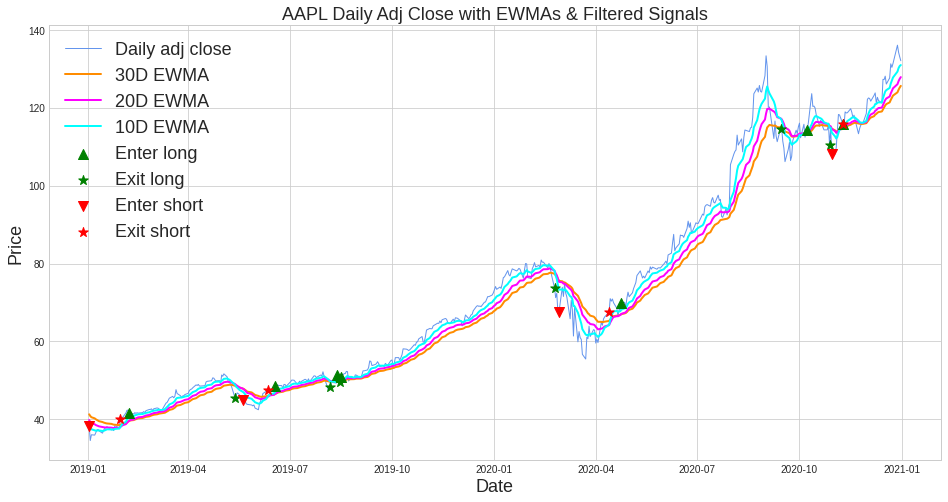

In [54]:
plt.figure(figsize=(16,8))
plt.plot(close_df.loc["2019-01-01":"2021-01-01","AAPL"], alpha=1.0, label="Daily adj close", linewidth=1, color="cornflowerblue", zorder=1)
plt.plot(slow_ewma_df.loc["2019-01-01":"2021-01-01","AAPL"], alpha=1.0, label="30D EWMA", linewidth=2, color="darkorange", zorder=2)
plt.plot(medium_ewma_df.loc["2019-01-01":"2021-01-01","AAPL"], alpha=1.0, label="20D EWMA", linewidth=2, color="magenta", zorder=3)
plt.plot(fast_ewma_df.loc["2019-01-01":"2021-01-01","AAPL"], alpha=1.0, label="10D EWMA", linewidth=2, color="cyan", zorder=4)

plt.scatter(filtered_long_signal.loc["2019-01-01":"2021-01-01","AAPL"].index,
            np.where(filtered_long_signal.loc["2019-01-01":"2021-01-01", "AAPL"]==1,close_df.loc["2019-01-01":"2021-01-01", "AAPL"], np.nan),
            alpha=1, label="Enter long", marker="^", color="green", s=100, zorder=5)
plt.scatter(filtered_long_signal.loc["2019-01-01":"2021-01-01","AAPL"].index,
            np.where(filtered_long_signal.loc["2019-01-01":"2021-01-01", "AAPL"]==-1,close_df.loc["2019-01-01":"2021-01-01", "AAPL"], np.nan),
            alpha=1, label="Exit long", marker="*", color="green", s=100, zorder=5)

plt.scatter(filtered_short_signal.loc["2019-01-01":"2021-01-01","AAPL"].index,
            np.where(filtered_short_signal.loc["2019-01-01":"2021-01-01", "AAPL"]==1,close_df.loc["2019-01-01":"2021-01-01", "AAPL"], np.nan),
            alpha=1, label="Enter short", marker="v", color="red", s=100, zorder=6)
plt.scatter(filtered_short_signal.loc["2019-01-01":"2021-01-01","AAPL"].index,
            np.where(filtered_short_signal.loc["2019-01-01":"2021-01-01", "AAPL"]==-1,close_df.loc["2019-01-01":"2021-01-01", "AAPL"], np.nan),
            alpha=1, label="Exit short", marker="*", color="red", s=100, zorder=6)

plt.title("AAPL Daily Adj Close with EWMAs & Filtered Signals", fontsize=18)
plt.legend(fontsize=18)
plt.xlabel("Date", fontsize=18)
plt.ylabel("Price", fontsize=18)
plt.show()

## Signal returns

In [55]:
def get_lookahead_returns(close, signal):

  entry_signals = signal.copy()
  entry_signals = entry_signals[signal==1]

  exit_signals = signal.copy()
  exit_signals = exit_signals[signal==-1]

  entry_prices = close.copy()
  entry_prices = entry_prices[signal==1]

  exit_prices = close.copy()
  exit_prices = exit_prices[signal==-1]

  price_returns = entry_prices.copy()

  for ticker in entry_prices:

    valid_entry_indexes = entry_prices.loc[:, ticker].index.get_indexer(entry_prices.loc[:, ticker].index[~entry_prices.loc[:, ticker].isnull()])
    valid_exit_indexes = exit_prices.loc[:, ticker].index.get_indexer(exit_prices.loc[:, ticker].index[~exit_prices.loc[:, ticker].isnull()])

    for i in range(len(valid_exit_indexes)):

      current_entry_price = entry_prices.loc[:, ticker].iloc[valid_entry_indexes[i]]
      current_exit_price = exit_prices.loc[:, ticker].iloc[valid_exit_indexes[i]]
      price_returns.loc[:, ticker].iloc[valid_entry_indexes[i]] = (current_exit_price / current_entry_price) - 1

    if len(valid_entry_indexes) > len(valid_exit_indexes):
      final_entry_price = entry_prices.loc[:, ticker].iloc[valid_entry_indexes[-1]]
      final_price = close.loc[:, ticker].iloc[-1]
      price_returns.loc[:, ticker].iloc[valid_entry_indexes[-1]] = (final_price / final_entry_price) - 1

  signal_returns = entry_signals * price_returns

  return signal_returns

In [56]:
signal_short_returns = get_lookahead_returns(close_df, filtered_short_signal) * (-1)
signal_short_returns

,AAPL
Date,
2019-01-02,-0.046416
2019-01-03,NaN
2019-01-04,NaN
2019-01-07,NaN
2019-01-08,NaN
...,...
2020-12-24,NaN
2020-12-28,NaN
2020-12-29,NaN


In [57]:
signal_long_returns = get_lookahead_returns(close_df, filtered_long_signal)
signal_long_returns

,AAPL
Date,
2019-01-02,NaN
2019-01-03,NaN
2019-01-04,NaN
2019-01-07,NaN
2019-01-08,NaN
...,...
2020-12-24,NaN
2020-12-28,NaN
2020-12-29,NaN


## Combined long and short signal returns

In [58]:
def combine_long_short_signal_returns(short_returns_df, long_returns_df):
  combined_returns_df = short_returns_df.fillna(0) + long_returns_df.fillna(0)
  combined_returns_df = combined_returns_df.replace(0, np.nan)
  return combined_returns_df

In [82]:
combined_signal_returns = combine_long_short_signal_returns(signal_short_returns, signal_long_returns)
#(combined_signal_returns.sum(axis=1)+1).cumprod()[-1]-1
combined_signal_returns

,AAPL
Date,
2019-01-02,-0.112718
2019-01-03,NaN
2019-01-04,NaN
2019-01-07,NaN
2019-01-08,NaN
...,...
2020-12-24,NaN
2020-12-28,NaN
2020-12-29,NaN


## Visualise signal returns

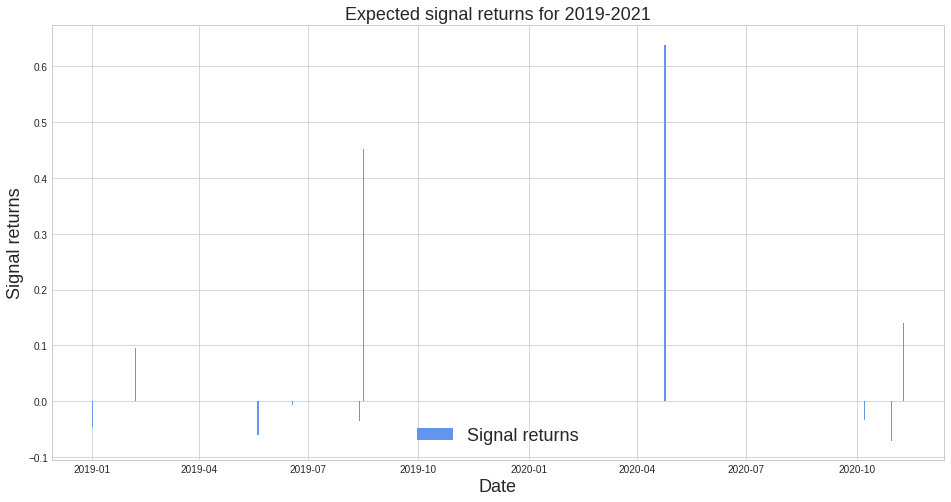

In [72]:
plt.figure(figsize=(16,8))
plt.bar(combined_signal_returns.index, combined_signal_returns.loc[:, "AAPL"], alpha=1.0, label="Signal returns", width=1, color="cornflowerblue", zorder=1)
plt.legend(fontsize=18)
plt.title("Expected signal returns for 2019-2021", fontsize=18)
plt.xlabel("Date", fontsize=18)
plt.ylabel("Signal returns", fontsize=18)
plt.show()

## Cumulative returns

In [74]:
signal_cumu_returns = ((combined_signal_returns / len(combined_signal_returns.columns)).sum(axis=1)+1).cumprod()
signal_cumu_returns

Date
2019-01-02    0.953584
2019-01-03    0.953584
2019-01-04    0.953584
2019-01-07    0.953584
2019-01-08    0.953584
                ...   
2020-12-24    2.294419
2020-12-28    2.294419
2020-12-29    2.294419
2020-12-30    2.294419
2020-12-31    2.294419
Length: 505, dtype: float64

In [76]:
buy_hold_cumu_returns = ((close_df / close_df.shift(1) - 1).sum(axis=1)+1).cumprod()
buy_hold_cumu_returns

Date
2019-01-02    1.000000
2019-01-03    0.900393
2019-01-04    0.938830
2019-01-07    0.936740
2019-01-08    0.954597
                ...   
2020-12-24    3.422230
2020-12-28    3.544629
2020-12-29    3.497433
2020-12-30    3.467611
2020-12-31    3.440902
Length: 505, dtype: float64

## Find optimal EWMA spans

In [63]:
stats_table = pd.DataFrame(data={"Stats":["Cumsum (2Y)", "CAGR", "Mean", "Median", "Max", "Min", "St. dev.","Skew", "Kurtosis"]})
stats_table.set_index("Stats", inplace=True)

buy_hold_returns = (close_df / close_df.shift(1) - 1).sum(axis=1)

stats_table["Buy & Hold"] = [(buy_hold_returns+1).cumprod()[-1]-1,
                            ((buy_hold_returns+1).cumprod()[-1])**(1/2)-1,
                            buy_hold_returns.mean(),
                            buy_hold_returns.median(),
                            buy_hold_returns.max(),
                            buy_hold_returns.min(), 
                            buy_hold_returns.std(), 
                            stats.skew(buy_hold_returns.dropna(axis=0)), 
                            stats.kurtosis(buy_hold_returns.dropna(axis=0), fisher=True)]

In [77]:
for i in range(5, 25, 5):
  for j in range(25, 65, 5):
    for k in range(65, 105, 5):

      # get close prices
      close_df = aapl_df.copy()
      close_df = close_df.drop(columns=["Open", "High", "Low", "Volume"])
      close_df = close_df.rename(columns={"Close":"AAPL"})

      # get EWMAs
      fast_ewma_df = close_df.copy()
      fast_ewma_df = EWMA(fast_ewma_df, i)
      medium_ewma_df = close_df.copy()
      medium_ewma_df = EWMA(medium_ewma_df, j)
      slow_ewma_df = close_df.copy()
      slow_ewma_df = EWMA(slow_ewma_df, k)

      # compute signals
      close_df = close_df.loc["2019-01-01":"2021-01-01", :]
      fast_ewma_df = fast_ewma_df.loc["2019-01-01":"2021-01-01", :]
      medium_ewma_df = medium_ewma_df.loc["2019-01-01":"2021-01-01", :]
      slow_ewma_df = slow_ewma_df.loc["2019-01-01":"2021-01-01", :]
      long_signals, short_signals = get_long_short(fast_ewma_df, medium_ewma_df, slow_ewma_df)

      # filter signal
      filtered_short_signal = filter_signal(short_signals)
      filtered_long_signal = filter_signal(long_signals)

      # get signal returns
      signal_short_returns = get_lookahead_returns(close_df, filtered_short_signal) * (-1)
      signal_long_returns = get_lookahead_returns(close_df, filtered_long_signal)
      signal_returns = combine_long_short_signal_returns(signal_short_returns, signal_long_returns).sum(axis=1)

      # enter signal return stats into table
      stats_table["{}D-Fast / {}D-Medium / {}D-Slow".format(i, j, k)] = [(signal_returns+1).cumprod()[-1]-1,
                                                                      ((signal_returns+1).cumprod()[-1])**(1/2)-1,
                                                                      signal_returns.mean(),
                                                                      signal_returns.median(),
                                                                      signal_returns.max(),
                                                                      signal_returns.min(), 
                                                                      signal_returns.std(), 
                                                                      stats.skew(signal_returns.dropna(axis=0)), 
                                                                      stats.kurtosis(signal_returns.dropna(axis=0), fisher=True)]  

In [78]:
stats_table

,Buy & Hold,5D-Fast / 25D-Medium / 65D-Slow,5D-Fast / 25D-Medium / 70D-Slow,5D-Fast / 25D-Medium / 75D-Slow,5D-Fast / 25D-Medium / 80D-Slow,5D-Fast / 25D-Medium / 85D-Slow,5D-Fast / 25D-Medium / 90D-Slow,5D-Fast / 25D-Medium / 95D-Slow,5D-Fast / 25D-Medium / 100D-Slow,5D-Fast / 30D-Medium / 65D-Slow,5D-Fast / 30D-Medium / 70D-Slow,5D-Fast / 30D-Medium / 75D-Slow,5D-Fast / 30D-Medium / 80D-Slow,5D-Fast / 30D-Medium / 85D-Slow,5D-Fast / 30D-Medium / 90D-Slow,5D-Fast / 30D-Medium / 95D-Slow,5D-Fast / 30D-Medium / 100D-Slow,5D-Fast / 35D-Medium / 65D-Slow,5D-Fast / 35D-Medium / 70D-Slow,5D-Fast / 35D-Medium / 75D-Slow,5D-Fast / 35D-Medium / 80D-Slow,5D-Fast / 35D-Medium / 85D-Slow,5D-Fast / 35D-Medium / 90D-Slow,5D-Fast / 35D-Medium / 95D-Slow,5D-Fast / 35D-Medium / 100D-Slow,5D-Fast / 40D-Medium / 65D-Slow,5D-Fast / 40D-Medium / 70D-Slow,5D-Fast / 40D-Medium / 75D-Slow,5D-Fast / 40D-Medium / 80D-Slow,5D-Fast / 40D-Medium / 85D-Slow,5D-Fast / 40D-Medium / 90D-Slow,5D-Fast / 40D-Medium / 95D-Slow,5D-Fast / 40D-Medium / 100D-Slow,5D-Fast / 45D-Medium / 65D-Slow,5D-Fast / 45D-Medium / 70D-Slow,5D-Fast / 45D-Medium / 75D-Slow,5D-Fast / 45D-Medium / 80D-Slow,5D-Fast / 45D-Medium / 85D-Slow,5D-Fast / 45D-Medium / 90D-Slow,5D-Fast / 45D-Medium / 95D-Slow,...,20D-Fast / 40D-Medium / 65D-Slow,20D-Fast / 40D-Medium / 70D-Slow,20D-Fast / 40D-Medium / 75D-Slow,20D-Fast / 40D-Medium / 80D-Slow,20D-Fast / 40D-Medium / 85D-Slow,20D-Fast / 40D-Medium / 90D-Slow,20D-Fast / 40D-Medium / 95D-Slow,20D-Fast / 40D-Medium / 100D-Slow,20D-Fast / 45D-Medium / 65D-Slow,20D-Fast / 45D-Medium / 70D-Slow,20D-Fast / 45D-Medium / 75D-Slow,20D-Fast / 45D-Medium / 80D-Slow,20D-Fast / 45D-Medium / 85D-Slow,20D-Fast / 45D-Medium / 90D-Slow,20D-Fast / 45D-Medium / 95D-Slow,20D-Fast / 45D-Medium / 100D-Slow,20D-Fast / 50D-Medium / 65D-Slow,20D-Fast / 50D-Medium / 70D-Slow,20D-Fast / 50D-Medium / 75D-Slow,20D-Fast / 50D-Medium / 80D-Slow,20D-Fast / 50D-Medium / 85D-Slow,20D-Fast / 50D-Medium / 90D-Slow,20D-Fast / 50D-Medium / 95D-Slow,20D-Fast / 50D-Medium / 100D-Slow,20D-Fast / 55D-Medium / 65D-Slow,20D-Fast / 55D-Medium / 70D-Slow,20D-Fast / 55D-Medium / 75D-Slow,20D-Fast / 55D-Medium / 80D-Slow,20D-Fast / 55D-Medium / 85D-Slow,20D-Fast / 55D-Medium / 90D-Slow,20D-Fast / 55D-Medium / 95D-Slow,20D-Fast / 55D-Medium / 100D-Slow,20D-Fast / 60D-Medium / 65D-Slow,20D-Fast / 60D-Medium / 70D-Slow,20D-Fast / 60D-Medium / 75D-Slow,20D-Fast / 60D-Medium / 80D-Slow,20D-Fast / 60D-Medium / 85D-Slow,20D-Fast / 60D-Medium / 90D-Slow,20D-Fast / 60D-Medium / 95D-Slow,20D-Fast / 60D-Medium / 100D-Slow
Stats,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Cumsum (2Y),2.440902,1.164449,0.838168,0.794894,0.915221,0.831297,0.812791,0.866581,0.881491,0.730037,0.759931,0.708020,0.731669,0.871286,0.720218,0.720218,0.580133,0.659378,0.731370,0.745200,0.563841,0.475288,0.475288,0.775103,0.754302,0.698823,0.522284,0.429445,0.459673,0.721403,0.753532,0.865951,0.786469,0.413148,0.361788,0.632347,0.664224,0.783850,0.681716,0.766596,...,0.766769,0.582202,0.485353,0.516762,0.790375,0.823711,0.941359,0.858098,0.628978,0.569397,0.882934,0.919620,1.058379,0.939936,1.038242,0.890758,0.405405,0.685779,0.689514,0.719990,0.774051,0.623681,0.641461,0.605595,0.764223,0.902289,0.818597,0.857918,0.692168,0.697644,0.868123,1.149671,0.870825,0.848759,0.688371,0.706860,0.658198,0.910506,1.114116,1.100057
CAGR,0.854967,0.471206,0.355790,0.339737,0.383915,0.353254,0.346399,0.366229,0.371675,0.315309,0.326624,0.306912,0.315929,0.367950,0.311571,0.311571,0.257034,0.288168,0.315815,0.321060,0.250536,0.214614,0.214614,0.332330,0.324501,0.303389,0.233809,0.195594,0.208169,0.312022,0.324210,0.365998,0.336588,0.188759,0.166957,0.277633,0.290048,0.335609,0.296810,0.329133,...,0.329199,0.257856,0.218750,0.231569,0.338049,0.350448,0.393327,0.363121,0.276314,0.252756,0.372200,0.385504,0.434705,0.392816,0.427670,0.375049,0.185498,0.298376,0.299813,0.311484,0.331935,0.274237,0.281195,0.267121

In [79]:
stats_table.loc["Cumsum (2Y)", :].nlargest(5)

Buy & Hold                           2.440902
10D-Fast / 60D-Medium / 95D-Slow     1.352068
10D-Fast / 60D-Medium / 100D-Slow    1.336427
5D-Fast / 55D-Medium / 100D-Slow     1.287271
10D-Fast / 60D-Medium / 90D-Slow     1.220592
Name: Cumsum (2Y), dtype: float64

In [80]:
stats_table.loc["Mean", :].nlargest(5)

Buy & Hold                           0.002734
10D-Fast / 60D-Medium / 95D-Slow     0.002340
10D-Fast / 60D-Medium / 100D-Slow    0.002328
15D-Fast / 55D-Medium / 100D-Slow    0.002238
10D-Fast / 60D-Medium / 90D-Slow     0.002229
Name: Mean, dtype: float64

In [81]:
stats_table.loc["St. dev.", :].nsmallest(5)

Buy & Hold                          0.023808
5D-Fast / 40D-Medium / 65D-Slow     0.027400
5D-Fast / 40D-Medium / 95D-Slow     0.027820
10D-Fast / 30D-Medium / 70D-Slow    0.027908
10D-Fast / 30D-Medium / 75D-Slow    0.028188
Name: St. dev., dtype: float64

In [84]:
stats_table.loc["Min", :].nlargest(5)

10D-Fast / 60D-Medium / 90D-Slow    -0.083782
10D-Fast / 60D-Medium / 95D-Slow    -0.083782
10D-Fast / 60D-Medium / 100D-Slow   -0.083782
5D-Fast / 30D-Medium / 70D-Slow     -0.084447
10D-Fast / 55D-Medium / 70D-Slow    -0.086771
Name: Min, dtype: float64